# **E-Commerce project: preprocessing data and making predictions**

The task is to predict actions in a webstore from features, such as a whether visitor is browsing from mobile, the number of products visited, the duration of the visit, etc.

## **Preprocessing data**

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def get_data():
  df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/ann_logistic_extra/ecommerce_data.csv')
  data = df.values

  X = data[:, :-1]
  Y = data[:,-1]

  # normalizing numerical columns
  X[:,1] = ( X[:,1] - X[:,1].mean() ) / X[:,1].std()
  X[:,2] = ( X[:,2] - X[:,2].mean() ) / X[:,2].std()

  # processing days
  N,D = X.shape
  X2 = np.zeros((N, D+3))
  X2[:,0:(D-1)] = X[:,0:(D-1)] # most columns are the same

  # now one-hot encoding of day categories
  #for n in range(N):
  #  t = int(X[n,D-1])
  #  X2[n,t+D-1] = 1

  # The same without for-loops
  Z = np.zeros((N,4))
  Z[np.arange(N),X[:,D-1].astype(np.int32)] = 1
  X2[:,-4:] = Z

  return X2, Y

# function to return data used for binary classification (only 0 and 1 categories)
# are used, others are discarded
def get_binary_data():
  X, Y = get_data()
  X2 = X[Y <= 1]
  Y2 = Y[Y <= 1]
  return X2, Y2



## **Making predictions**

Making predictions, now only using random weights:

In [59]:
def sigmoid(z):
  return 1. / (1. + np.exp(-z))

In [60]:
def forward(X,w,b):
  return sigmoid(X @ w + b)

In [61]:
def classification_rate(Y,P):
  return np.mean(Y == P)

In [62]:
X, Y = get_binary_data()

D = X.shape[1]
w = np.random.randn(D)
b = 0

P_Y_given_X = forward(X,w,b)
predictions = np.round(P_Y_given_X) # 0 if P(Y|X) < 0.5 and 1 otherwise
print("Score: ", classification_rate(Y,predictions))

Score:  0.2638190954773869


## **Training the logistic model**

Creating the necessary functions and classes:
* Cross-entropy calculation
* Standardization
* Train/test splitting
* Gradient descent
* Logistic regression class

In [63]:
def cross_entropy(t,y):
  return - ( t * np.log(y) + (1 - t) * np.log(1-y) ).sum()

In [64]:
# Standardize a vector or rows of a matrix
def standardize(A):
  return (A - A.mean(axis=0))/A.std(axis=0)

# Split data into train and test sets
def train_test_split(X,y, test_ratio):
  # Shuffling both vector in unison
  p = np.random.permutation(X.shape[0])
  X_shuffled = X[p]
  y_shuffled = y[p]

  n_test = int(0.3*X.shape[0])

  X_test = X_shuffled[:n_test,:]
  y_test = y_shuffled[:n_test]
  X_train = X_shuffled[n_test:,:]
  y_train = y_shuffled[n_test:]
  return X_train, y_train, X_test, y_test

In [74]:
# Function to perform gradient descent

def gradient_descent(x0,func,gradient,learning_rate=0.001,max_iter=2000):
  x_new = x0
  values = [func(x0)]
  i = 0
  while( i < max_iter ):
    x_new = x_new - learning_rate*gradient(x_new)
    values.append(func(x_new))
    i += 1
  return x_new, values

In [70]:
# Logistic regression class

class LogisticRegression:
  def add_ones(self,X):
    if X.ndim == 1:
      X.shape = [1,X.shape[0]]
    return np.column_stack( (np.ones(X.shape[0]),X) )

  def fit(self,X,t):
    # Add a column of ones
    Xb = self.add_ones(X)
    # randomly initialize weights
    D = Xb.shape[1]
    self.w = np.random.randn(D) #/ np.sqrt(D)
    #self.w = np.array([0,4,4]) #
    # passing objective function and gradient as a lambda to gradient descent function
    J = lambda w : cross_entropy(t, sigmoid(Xb @ w) )
    gradient = lambda w : Xb.T @ (sigmoid(Xb @ w) - t)
    self.w, self.cost = gradient_descent(self.w,J,gradient)
    self.cost_test

  def forward(self,X):
    # Add a column of ones
    Xb = self.add_ones(X)
    return np.round(sigmoid(Xb @ self.w))

  # Just to have the usual predict method as well
  def predict(self,X):
    return self.forward(X)

  def score(self,X,t):
    return np.mean( t == self.predict(X) )

And now, finally training the model:

Accuracy 0.9831932773109243


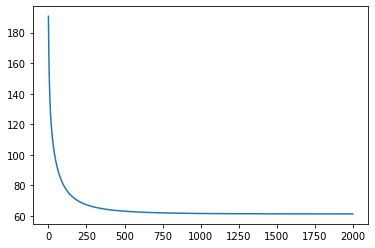

In [76]:
X_train, Y_train, X_test, Y_test = train_test_split(X,Y,0.1)

model = LogisticRegression()
model.fit(X_train, Y_train)
print("Accuracy",model.score(X_test, Y_test))

plt.plot(model.cost);